# Градиентный спуск

В этом проекте напишем градиентный спуск для линейной регрессии, а так же посмотрим, как он ведёт себя с разными параметрами и разными функциями потерь.

In [ ]:
from typing import Iterable, List

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
import numpy as np

## Реализация градиентного спуска

Самый простой функционал ошибки, который мы применяем в задаче регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

Ниже приведён базовый класс `BaseLoss`, который мы будем использовать для реализации всех наших лоссов. Менять его не нужно. У него есть два абстрактных метода:
1. Метод `calc_loss`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения лосса
2. Метод `calc_grad`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения градиента (вектор)

In [ ]:
import abc


class BaseLoss(abc.ABC):
    """Базовый класс лосса"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

Абстрактный класс `MSELoss` вычисляет лосс и градиент по формулам наверху.

In [ ]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        return (1/X.shape[0])*np.sum(np.square(X.dot(w) - y))

        # значение функции потерь при помощи X, y и w

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        return (2/X.shape[0])*X.T.dot(X.dot(w) - y)
        # (2/y.shape[0])*(np.dot(X.T, (np.dot(X, w) - y)))
        # значение вектора градиента при помощи X, y и w

In [ ]:
# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

Реализуем функцию `gradient_descent`

Функция должна принимать на вход начальное значение весов линейной модели `w_init`, матрицу объектов-признаков `X`,
вектор правильных ответов `y`, объект функции потерь `loss`, размер шага `lr` и количество итераций `n_iterations`.

Функция должна реализовывать цикл, в котором происходит шаг градиентного спуска (градиенты берутся из `loss` посредством вызова метода `calc_grad`) по формуле выше и возвращать
траекторию спуска (список из новых значений весов на каждом шаге)

In [ ]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    w_list = [w_init]

    for i in range(n_iterations):
        w_list.append(w_init)
        w_init = w_init-lr*loss.calc_grad(X, y, w_init)

    return w_list

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории:

In [ ]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [ ]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

425.5891768045026
0.8670644395649652


In [ ]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect("equal")

    # visualize the level set
    CS = plt.contour(
        A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r
    )
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

При помощи функций `gradient_descent` и  `plot_gd` нарисуем траекторию градиентного спуска для разных значений длины шага (параметра `lr`).

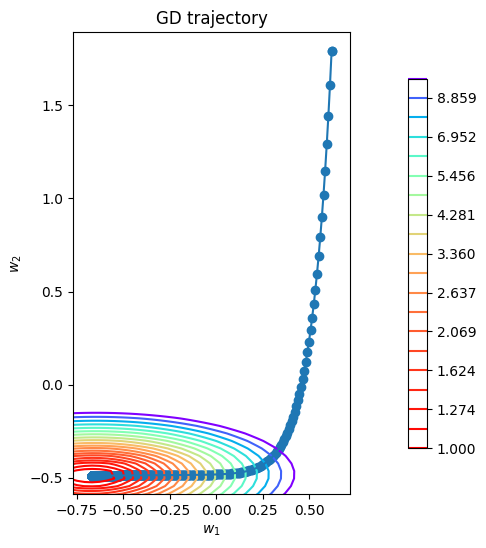

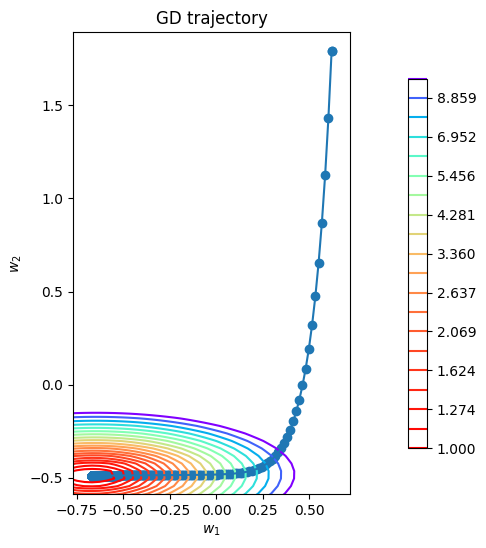

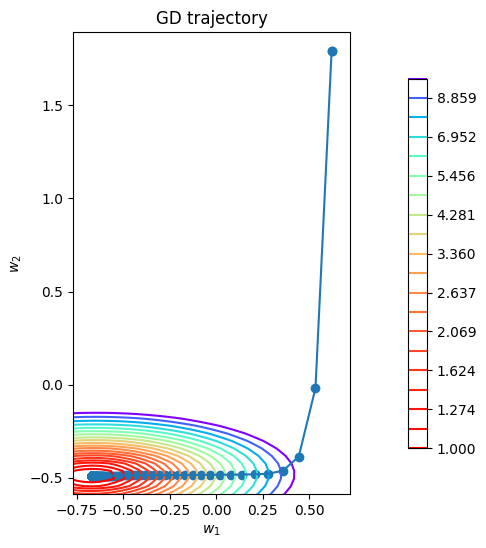

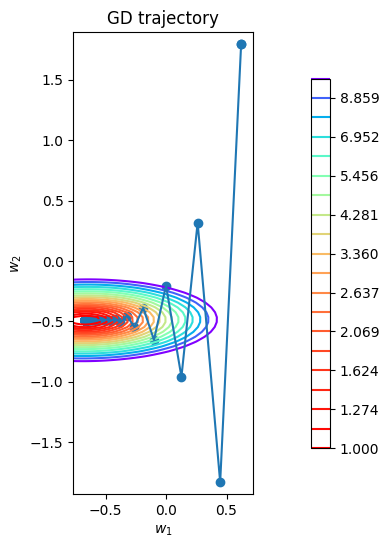

In [ ]:
lrs = [0.0005, 0.001, 0.005, 0.01]
for lr in lrs:
    plot_gd(gradient_descent(w_init, X, y, loss, lr), X, y, loss)

Параметр lr влияет на поведение градиентного спуск следующим образом: чем меньше его значение, тем медленнее снижается ошибка, но при этом повышается вероятность нахождения локального минимума; чем значение больше, тем быстрее снижается ошибка, но и увеличивается риск переобучения.

Теперь реализуем стохастический градиентный спуск

Реализуйем функцию `stochastic_gradient_descent`

Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча.

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

In [ ]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    w_list = [w_init]

    for i in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        batch = X[batch_indices]

        w_init = w_init-lr*loss.calc_grad(batch, y[batch_indices], w_init)
        w_list.append(w_init)

    return w_list

При помощи функций `stochastic_gradient_descent` и  `plot_gd` нарисуем траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`).

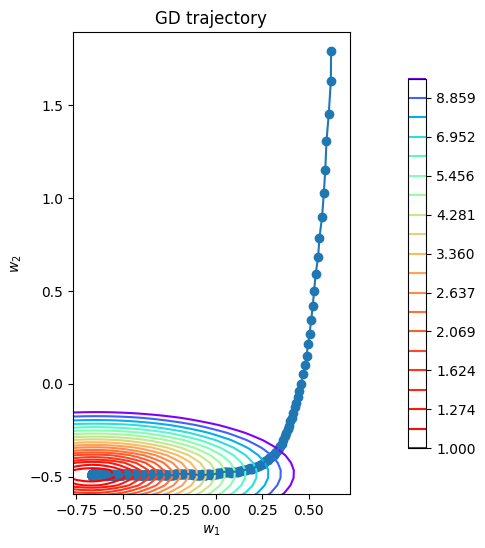

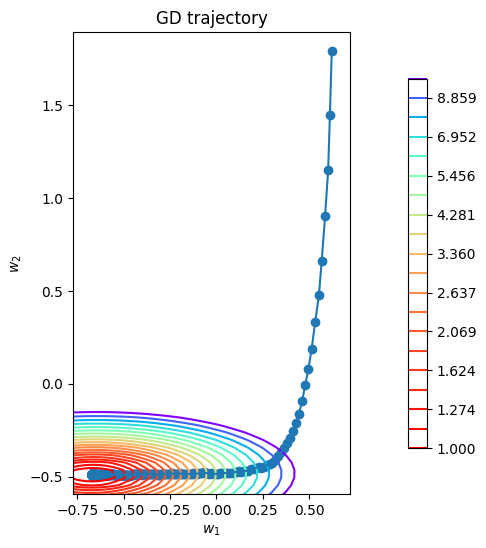

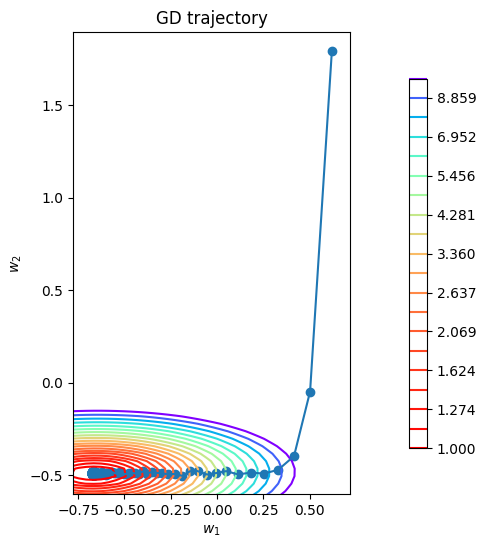

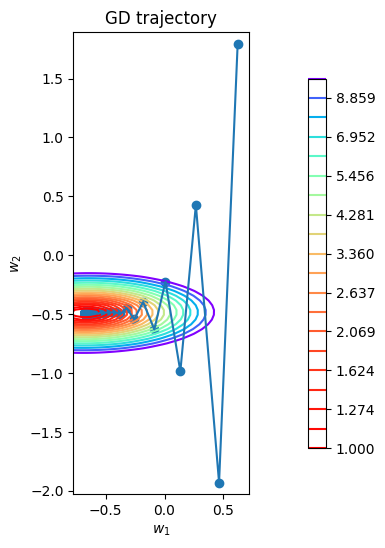

In [ ]:
lrs = [0.0005, 0.001, 0.005, 0.01]
batch_sizes = [100, 150, 200, 250]
for lr, batch_size in zip(lrs, batch_sizes):
    plot_gd(stochastic_gradient_descent(w_init, X, y, loss, lr, batch_size), X, y, loss)

Параметры lr и batch_size влияют на поведение стохастического градиентного спуска следующим образом: чем больше batch_size, тем медленнее обучение, но слишком маленькое значение может привести к застреванию в локальных минимумах;  чем меньше lr, тем медленнее снижается ошибка, но при этом повышается вероятность нахождения локального минимума, и чем lr больше, тем быстрее снижается ошибка, но и увеличивается риск переобучения.

В отличие от обычного градиентного спуска стохастический использует случайные выборки вместо полных наборов данных для корректировки весов, благодаря чему он менее предрасположен к переобучению.

Поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага.

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы более точнее этого минимума достичь и не "перепрыгнуть" его.

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

Реализуем функцию `stochastic_gradient_descent` на этот раз с затухающим шагом по формуле выше.

In [ ]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param p: float -- значение степени в формуле затухания длины шага
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    w_list = [w_init]

    for i in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        batch = X[batch_indices]
        w_init = w_init-(lr*(1/(1+i))**p)*loss.calc_grad(batch, y[batch_indices], w_init)
        w_list.append(w_init)

    return w_list

При помощи новой функции `stochastic_gradient_descent` и функции `plot_gd` нарисуем траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`. Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.

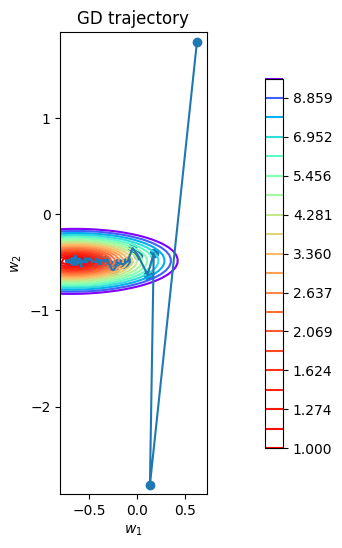

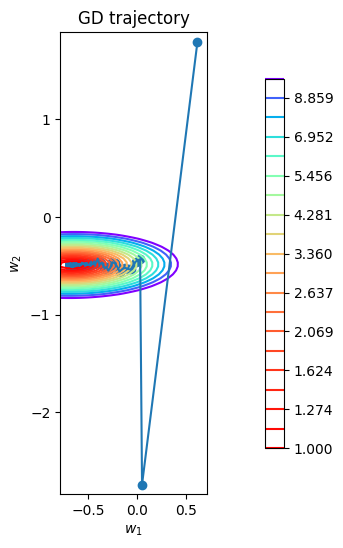

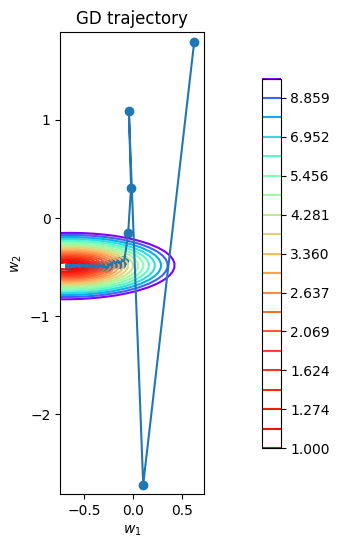

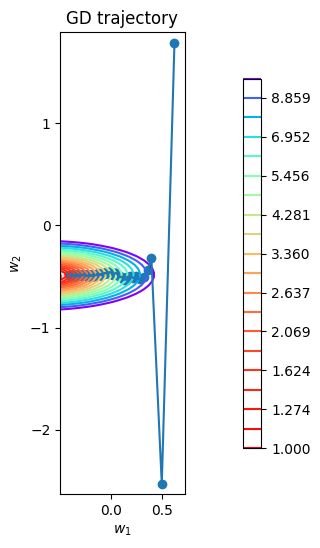

In [ ]:
lr = 0.01
batch_size = 10
p = [0.3, 0.5, 0.7, 0.9]

for i in p:
    plot_gd(stochastic_gradient_descent(w_init, X, y, loss, lr, batch_size, i), X, y, loss)

Параметр p влияет на поведение стохастического градиентного спуска следующим образом: чем больше его значение, тем лучше сходимость, т.е. алгоритм работает быстрее.

Сравним сходимость обычного градиентного спуска и стохастичекой версии:
нарисуем график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами.

In [ ]:
lr = 0.01
batch_size = 10
p = 0.9

w_list_GD = gradient_descent(w_init, X, y, loss, lr)
w_list_SGD = stochastic_gradient_descent(w_init, X, y, loss, lr, batch_size, p)

loss_SGD = [loss.calc_loss(X=X, y=y, w=w_list_SGD[i]) for i in range(len(w_list_SGD))]
loss_GD = [loss.calc_loss(X=X, y=y, w=w_list_GD[i]) for i in range(len(w_list_GD))]

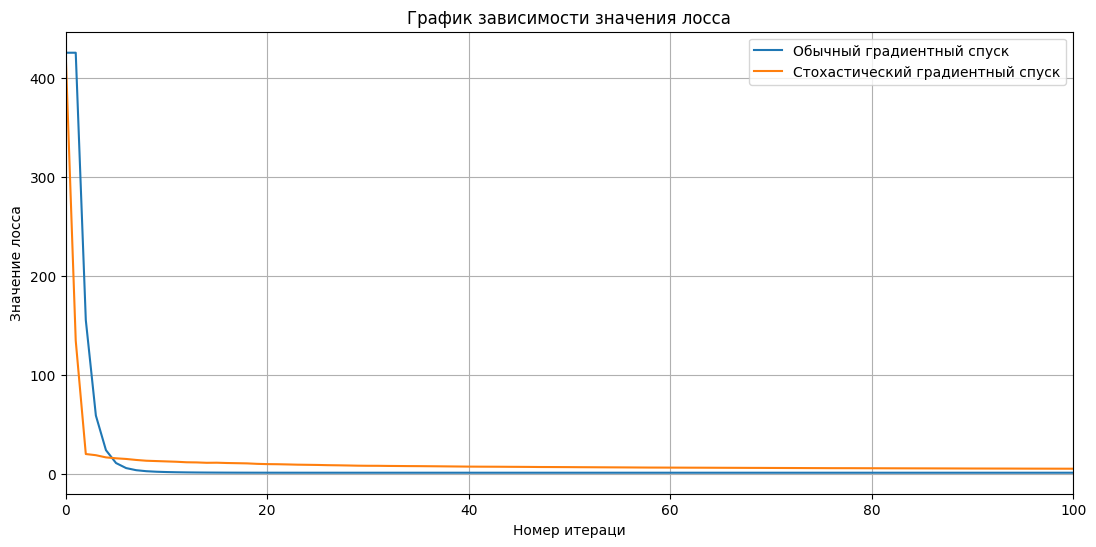

In [ ]:
plt.figure(figsize=(13, 6))
plt.plot(loss_GD, label="Обычный градиентный спуск")
plt.plot(loss_SGD, label="Стохастический градиентный спуск")

plt.title("График зависимости значения лосса")
plt.legend()
plt.xlim((0, 100))
plt.ylabel("Значение лосса")
plt.xlabel("Номер итераци")
plt.grid()
plt.show()

## Реализация линейной регрессии

Теперь напишем наш класс для линейной регрессии.

В методе `fit` будем подбирать веса `w` при помощи градиентного спуска методом `gradient_descent`

В методе `predict` будем применять нашу регрессию к датасету,

In [ ]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        # Инициализируем веса w и сохранеям последнюю из траектории
        self.w = gradient_descent(X=X, y=y, w_init=np.arange(X.shape[1]), loss=self.loss, lr=self.lr)[-1]
        # print(w.shape)
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        y_pred = np.dot(X, self.w)

        return y_pred

Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [ ]:
linear_regression = LinearRegression(MSELoss())

Применим нашу регрессию на реальном датасете.

In [ ]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)
X_raw.head()
X_raw = X_raw[~X_raw[25].isna()].reset_index()

y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

Обработаем датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from numpy import nan
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import warnings

import matplotlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler


In [ ]:
X_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   201 non-null    int64  
 1   0       201 non-null    int64  
 2   1       164 non-null    float64
 3   2       201 non-null    object 
 4   3       201 non-null    object 
 5   4       201 non-null    object 
 6   5       199 non-null    object 
 7   6       201 non-null    object 
 8   7       201 non-null    object 
 9   8       201 non-null    object 
 10  9       201 non-null    float64
 11  10      201 non-null    float64
 12  11      201 non-null    float64
 13  12      201 non-null    float64
 14  13      201 non-null    int64  
 15  14      201 non-null    object 
 16  15      201 non-null    object 
 17  16      201 non-null    int64  
 18  17      201 non-null    object 
 19  18      197 non-null    float64
 20  19      197 non-null    float64
 21  20      201 non-null    float64
 22  21

In [ ]:
print("Пропущенные значения в наборе данных:", 'есть' if X_raw.isna().any().any() else 'нет')

Пропущенные значения в наборе данных: есть


In [ ]:
# Для вещественнозначных признаков заполним пропуски средними
X_float = X_raw[X_raw.columns[(X_raw.dtypes == "float64").values]]
mis_replacer = SimpleImputer(strategy="mean")
X_no_mis_float = pd.DataFrame(data=mis_replacer.fit_transform(X_float), columns=X_float.columns)
# Для целочисленных признаков заполним пропуски средними
X_no_mis_int = X_raw[X_raw.columns[(X_raw.dtypes == "int64").values]].fillna(round(X_raw[X_raw.columns[(X_raw.dtypes == "int64").values]].mean()))
# Нормализуем числовые признаки
scaler = StandardScaler()
scaler.fit(X_no_mis_float)
X_no_mis_float = pd.DataFrame(data=scaler.transform(X_no_mis_float))
# Для категориальных пустыми строками
X_no_mis_cat = X_raw[X_raw.columns[(X_raw.dtypes == "object").values]].fillna("")
X_no_mis = pd.concat([X_no_mis_float, X_no_mis_int, X_no_mis_cat], axis=1)


In [ ]:
print("Пропущенные значения в наборе данных:", 'есть' if X_no_mis.isna().any().any() else 'нет')

Пропущенные значения в наборе данных: нет


In [ ]:
# Удаляем из набора данных признаки, не несущие дополнительной информации
#X_no_mis = X_no_mis.drop('index', axis=1)

In [ ]:
# Закодируем категориальные переменные
X_no_mis = pd.get_dummies(X_no_mis, drop_first=True)

In [ ]:
# Разделим датасет на обучающую и тестовую выборку
np.random.seed(27)
x_train, x_test, y_train, y_test = train_test_split(X_no_mis, y, test_size = 0.3, random_state=27)

Обучим написанную линейную регрессию на обучающей выборке

In [ ]:
linear_regression.fit(x_train, y_train)

<ipython-input-676-34776121b687>:23: RuntimeWarning: invalid value encountered in subtract
  w_init = w_init-lr*loss.calc_grad(X, y, w_init)


(10,)


In [ ]:
x_train.shape

In [ ]:
from sklearn.metrics import mean_squared_error

print(f"Среднеквадратическая ошибка линейной регрессии на тренировочной выборке: {mean_squared_error(y_train, linear_regression.predict(x_train))}")
print(f"Среднеквадратическая ошибка линейной регрессии на тестовой выборке: {mean_squared_error(y_test, linear_regression.predict(x_test))}")

Модель переобучилась, добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

Реализуем класс `MSEL2Loss`

Он должен вычислять лосс и градиент по формулам наверху

In [ ]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        """
        :param coef: коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета. Последний признак константный.
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии. Последний вес -- bias.
        :output: число -- значения функции потерь
        """
        # Значение функции потерь при помощи X, y и w
        return (1/y.shape[0])*np.sum((np.dot(X, w) - y)**2) + self.coef*(w[:-1]**2)

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        # Значение вектора градиента при помощи X, y и w
        return (2/y.shape[0]) * np.dot(X.T, (np.dot(X, w) - y)) + 2*self.coef*np.append(w[:-1], 0)

In [ ]:
linear_regression.fit(x_train, y_train)
print(f"Среднеквадратическая ошибка линейной регрессии на тренировочной выборке: {mean_squared_error(y_train, linear_regression.predict(x_train))}")
print(f"Среднеквадратическая ошибка линейной регрессии на тестовой выборке: {mean_squared_error(y_test, linear_regression.predict(x_test))}")

С выбросами хорошо помогает бороться Huber Loss, в дали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE.

Функция потерь Huber Loss'а  выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

In [ ]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        """
        :param eps: параметр huber loss из формулы
        """
        self.eps = eps

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значения функции потерь
        """
        z = np.dot(X, w) - y
        return np.where(abs(z)<self.eps, X.T.dot(z**2), X.T.dot(abs(z)-0.5*self.eps))
        # Вычислите значение функции потерь при помощи X, y и w и верните его

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        z = np.dot(X, w) - y
        return np.where(abs(z)<self.eps, X.T.dot(z), X.T.dot(np.sign(z))*self.eps)
        # Вычислите значение вектора градиента при помощи X, y и w и верните его

In [ ]:
linear_regression = LinearRegression(HuberLoss(eps=50))
linear_regression.fit(x_train, y_train)
print(f"Среднеквадратическая ошибка линейной регрессии на тренировочной выборке: {mean_squared_error(y_train, linear_regression.predict(X_train))}")
print(f"Среднеквадратическая ошибка линейной регрессии на тестовой выборке: {mean_squared_error(y_test, linear_regression.predict(X_test))}")